# ICE
For further explanation of the methods functioning and the reasoning behind the experiments, refer to the project report where everything is described in detail.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets

import numpy as np

import sys

import warnings
warnings.filterwarnings("ignore")

In [3]:
# clone repository
!git clone https://github.com/aapokrki/t_xai_project.git

# change path to ICE folder
%cd t_xai_project/ICE

sys.path.append('/content/t_xai_project/ICE')

In [4]:
# import specific files from ICE folder
from ConceptExtractor import ConceptExtractor
from utils_ICE import forward_from_layer, calc_concept_number, plot_TCAV, calc_avg_concept_presence, plot_concept_images

## Loading Model and Preparing Data

In [5]:
def load_data(batch_size=256, num_workers=0, shuffle_train=False):
   # transformation pipleine from pytorch vgg16 documentation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
    ])

    train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

    # create dataloaders for batching
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_train, num_workers=num_workers)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader


In [6]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
print(model)

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg16_bn-6ee7ea24.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg16_bn-6ee7ea24.pt
100%|██████████| 58.3M/58.3M [00:00<00:00, 106MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Applying Invertible Concecpt-based Explanations
The technique is implemented manually and implementation details can be found in ncav_utils.py and ConceptExtractor.py <br>
We will use batch zero for training the reducer (retrieving the concepts from the train set) and then evaluate the concepts on the whole test dataset. We choose an activation layer in the middle as the ones in the end provide too coarse concepts and the ones at the beginning only focus on simple features. The final layer decision is based on the optimal number of concepts that are found using the consine similarity that have a reasonable number of concepts s.t. they are human-understandable.

In [7]:
# take batch and extract activations from model for train batch
train_loader, test_loader = load_data(batch_size=512, num_workers=0)
train_batch0 = next(iter(train_loader))
print(f"reducer training samples: {train_batch0[0].shape}, lables: {train_batch0[1].shape}")
print(f"label distribution: {torch.bincount(train_batch0[1], minlength=10)}")

# register forward hook for model to extract specific activation layers
# always use a ReLU activated layer as we apply NMF on it
target_layers = [36, 32, 29, 26, 22, 19] # 42 last layer, 39 - penultimate layer
activations = {}
train_hooks = []

def hook_fn(name):
    # hook function to store activations
    def fn(module, input, output): # actual hook function
        """
        module: layer itself
        input: input to layer
        output: output of layer
        """
        activations[name] = output.detach()
    return fn # returns created hook function

for target_layer in target_layers:
    hook = model.features[target_layer].register_forward_hook(hook_fn(f"layer_{target_layer}"))
    train_hooks.append(hook)

# forward pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_batch0_samples, train_batch0_labels = train_batch0
train_batch0 = train_batch0_samples.to(device)

model.eval()
with torch.no_grad():
    train_batch0_logits = model(train_batch0_samples)

# checking activation shapes for layers and if they are actually nonzero
for name, activation in activations.items():
    print(f"{name} activation shape: {activation.shape}, nonzero: {torch.all(activation >= 0)}")


# remove hooks:
for hook in train_hooks:
    hook.remove()

100%|██████████| 170M/170M [00:05<00:00, 31.8MB/s]


reducer training samples: torch.Size([512, 3, 32, 32]), lables: torch.Size([512])
label distribution: tensor([52, 66, 45, 47, 51, 41, 53, 50, 49, 58])
layer_19 activation shape: torch.Size([512, 256, 8, 8]), nonzero: True
layer_22 activation shape: torch.Size([512, 256, 8, 8]), nonzero: True
layer_26 activation shape: torch.Size([512, 512, 4, 4]), nonzero: True
layer_29 activation shape: torch.Size([512, 512, 4, 4]), nonzero: True
layer_32 activation shape: torch.Size([512, 512, 4, 4]), nonzero: True
layer_36 activation shape: torch.Size([512, 512, 2, 2]), nonzero: True


In [8]:
# test forward form layer function - used later to calculate TCAV scores
output1 = train_batch0_logits.clone().detach() # reuse computations from train batch 0
output2 = forward_from_layer(model, activations["layer_19"].clone(), layer=20)
output3 = forward_from_layer(model, activations["layer_29"].clone(), layer=30)
assert torch.all(output1 == output2), "outputs 1 & 2 do not coincide"
assert torch.all(output1 == output3), "outputs 1 & 3 do not coincide"

With this, we have now a function that can continue the forward pass of the model from any specified feature extractor layer.

One drawback of the method, is the hyperparameter selection for NMF. The number of concepts must be determined beforehand. In the literature, using the cosine similarity to measure the similarity of concepts and enforcing them to be dissimilar to a certain degree. Thus, we try this with our dataset and see if we get a meaningful number of concepts for different thresholds [0.1, 0.2, 0.3, 0.4, 0.5].

In [ ]:
# Note: very long execution time! 
# So if not interested, execution of this cell is not needed for the following experiments

# retrieve the optimal concept number according to the cosine similarity for determined thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
concept_dicts = []
# itereate over all layers defined earlier
for target_layer in target_layers:
    layer_idx = f"layer_{target_layer}"
    A = activations[layer_idx].clone().numpy() # get layer and convert tensor to numpy
    A = np.transpose(A, (0, 2, 3, 1)) # reshape A to batch_size, height, width, channels
    concept_dict = calc_concept_number(thresholds, A, 20)
    concept_dicts.append(concept_dict)
    print(f"\n----Layer {target_layer}---")
    for threshold, concept in concept_dict.items():
        print(f"threshold: {threshold} - nr of concepts: {concept[0]}")


----Layer 36---
threshold: 0.1 - nr of concepts: 1
threshold: 0.2 - nr of concepts: 1
threshold: 0.3 - nr of concepts: 1
threshold: 0.4 - nr of concepts: 17
threshold: 0.5 - nr of concepts: 20

----Layer 32---
threshold: 0.1 - nr of concepts: 1
threshold: 0.2 - nr of concepts: 1
threshold: 0.3 - nr of concepts: 3
threshold: 0.4 - nr of concepts: 20
threshold: 0.5 - nr of concepts: 20

----Layer 29---
threshold: 0.1 - nr of concepts: 1
threshold: 0.2 - nr of concepts: 1
threshold: 0.3 - nr of concepts: 10
threshold: 0.4 - nr of concepts: 18
threshold: 0.5 - nr of concepts: 20

----Layer 26---
threshold: 0.1 - nr of concepts: 1
threshold: 0.2 - nr of concepts: 1
threshold: 0.3 - nr of concepts: 5
threshold: 0.4 - nr of concepts: 20
threshold: 0.5 - nr of concepts: 20

----Layer 22---
threshold: 0.1 - nr of concepts: 1
threshold: 0.2 - nr of concepts: 1
threshold: 0.3 - nr of concepts: 20
threshold: 0.4 - nr of concepts: 20
threshold: 0.5 - nr of concepts: 20

----Layer 19---
threshold: 

It can be seen that with the cosine similarity we get mostly either 20 concepts or 1 concept. We expect one concept too limiting for 10 classes and 20 too much to be humanly-understandable. Thus, we fix layer 29 with 10 concepts as this seems to be a reasonable number that should be interpretable.

In [9]:
# get our final concept extractor - calculate the 10 concepts applied on the test dataset
A = activations["layer_29"].clone().numpy() # get layer and convert tensor to numpy
A = np.transpose(A, (0, 2, 3, 1)) # reshape A to batch_size, height, width, channels
ConceptExtractor_final = ConceptExtractor(A, seed=1234)
ConceptExtractor_final.apply_NMF(nr_concepts=10)

We have trained the reducer (extracted the 10 learned cooncepts) and can apply the concepts now to our test dataset. 

In [14]:
# get all activations from test loader

# register forward hook for model to extract specific activation layers
target_layers = [29] # 42 last layer, 39 - penultimate layer
test_activations = {f"layer_{layer}": [] for layer in target_layers}
test_labels = []
test_hooks = []

# hook function to store activations
def hook_fn(name):
    def fn(module, input, output): # actual hook function
        """
        module: layer itself
        input: input to layer
        output: output of layer
        """
        test_activations[name].append(output.detach())
    return fn # returns created hook function

for target_layer in target_layers:
    hook = model.features[target_layer].register_forward_hook(hook_fn(f"layer_{target_layer}"))
    test_hooks.append(hook)

model = model.to(device)
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        test_labels.append(target)
        model(data)

for hook in test_hooks:
    hook.remove()

#### TCAV Scores
Next, we plot the TCAV scores for each concept and each class for 1 train and 1 test batch (512 samples) each. Note, we decided against calculating TCAV scores on the whole datasets as we need to perform 2 forward passes each which is computationally costly. The formulas used for implementing TCAV are found in the report.

In [24]:
# split the activations according to their classes
class_activations = [[] for _ in range(10)]

for batch_activations, batch_labels in zip(test_activations["layer_29"], test_labels):
    for idx in range(10):
        # filtering the samples from specific class
        mask = (batch_labels == idx)
        class_activations_batch = batch_activations[mask]
        class_activations[idx].append(class_activations_batch)

# concatenate all class lists to one big batch
for i in range(10):
    class_activations[i] = torch.cat(class_activations[i], dim=0)

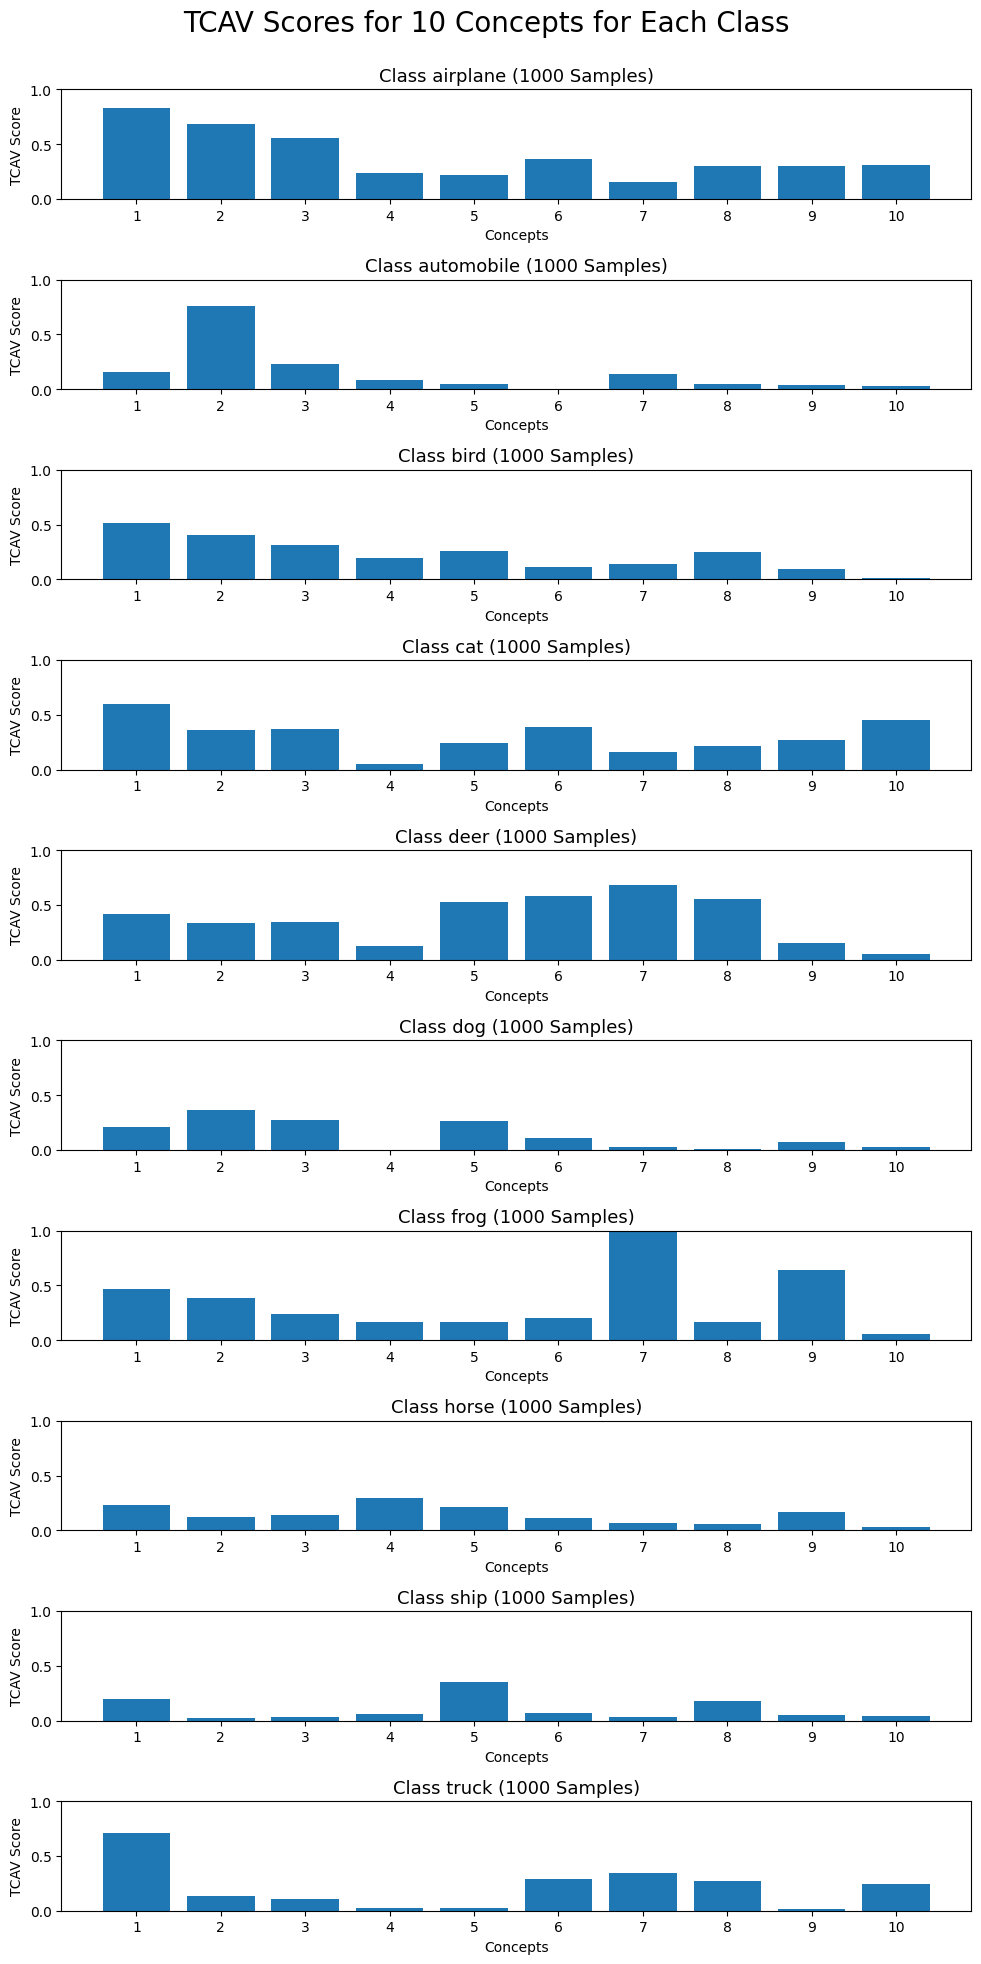

In [26]:
# Note: very long execution time! 

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
TCAV_save_path_test = 'TCAV_test.pdf'
plot_TCAV(class_activations, ConceptExtractor_final, classes, model, layer_name=30, save_path=TCAV_save_path_test)

#### Visualizing Prototypical (and Atypical) Images for Concepts

Next, we look for the presence of the extracted concepts in our test set.
Therefore, we will calculate the average concept presence for each concept in each image and extract the top samples for each concept that has the highest and lowest presence. These should give an idea of what a concept (not) is.

In [ ]:
Explainer_S = [] # holds the information for each activation map regarding the presence of a concept

for target_layer, test_activations_layer in test_activations.items():
  # get model activations for batch
  for idx in range(len(test_activations_layer)):
    A_test = test_activations_layer[idx].numpy()
    A_test = np.transpose(A_test, (0, 2, 3, 1))

    # apply the explainer (the already fitted NMF model)
    S = ConceptExtractor_final.explainer(A_test, batch_size=A_test.shape[0])
    Explainer_S.append(S)

avg_concept_presence = calc_avg_concept_presence(5, Explainer_S, test_loader, ConceptExtractor_final)

In [ ]:
Explainer_S_all = []
heatmaps = []

for batch_idx, (data, target) in enumerate(test_loader):
    S = Explainer_S[batch_idx].copy()
    S = S.reshape((
        data.shape[0],
        ConceptExtractor_final.height,
        ConceptExtractor_final.width,
        ConceptExtractor_final.nr_concepts
    ))

    S_reshaped = S.copy()
    S_reshaped = np.transpose(S_reshaped, (0, 3, 1, 2)) #needed for interpolating S: batch_size x channels x height x width
    # heatmap size fits our log mel spectrograms, if others are used, then change size
    heatmap_batch = torch.nn.functional.interpolate(torch.from_numpy(S_reshaped), size=(32, 32), mode='bilinear', align_corners=False)

    # normalize the heatmaps
    normalized_heatmaps = np.zeros_like(heatmap_batch, dtype=np.float32)

    for b in range(data.shape[0]):
        for c in range(ConceptExtractor_final.nr_concepts):
            img_concept = heatmap_batch[b, c, :, :]
            min_val = torch.min(img_concept)
            max_val = torch.max(img_concept)

            normalized_img_concept = (img_concept - min_val) / (max_val - min_val)

            # thresholding the heatmaps s.t. concepts are larger than threshold
            #normalized_img_concept[normalized_img_concept < threshold] = 0
            normalized_heatmaps[b, c, :, :] = normalized_img_concept

    flattened_batch = [S[i] for i in range(S.shape[0])]
    Explainer_S_all.extend(flattened_batch)
    flattened_batch = [normalized_heatmaps[i] for i in range(normalized_heatmaps.shape[0])]
    heatmaps.extend(flattened_batch)

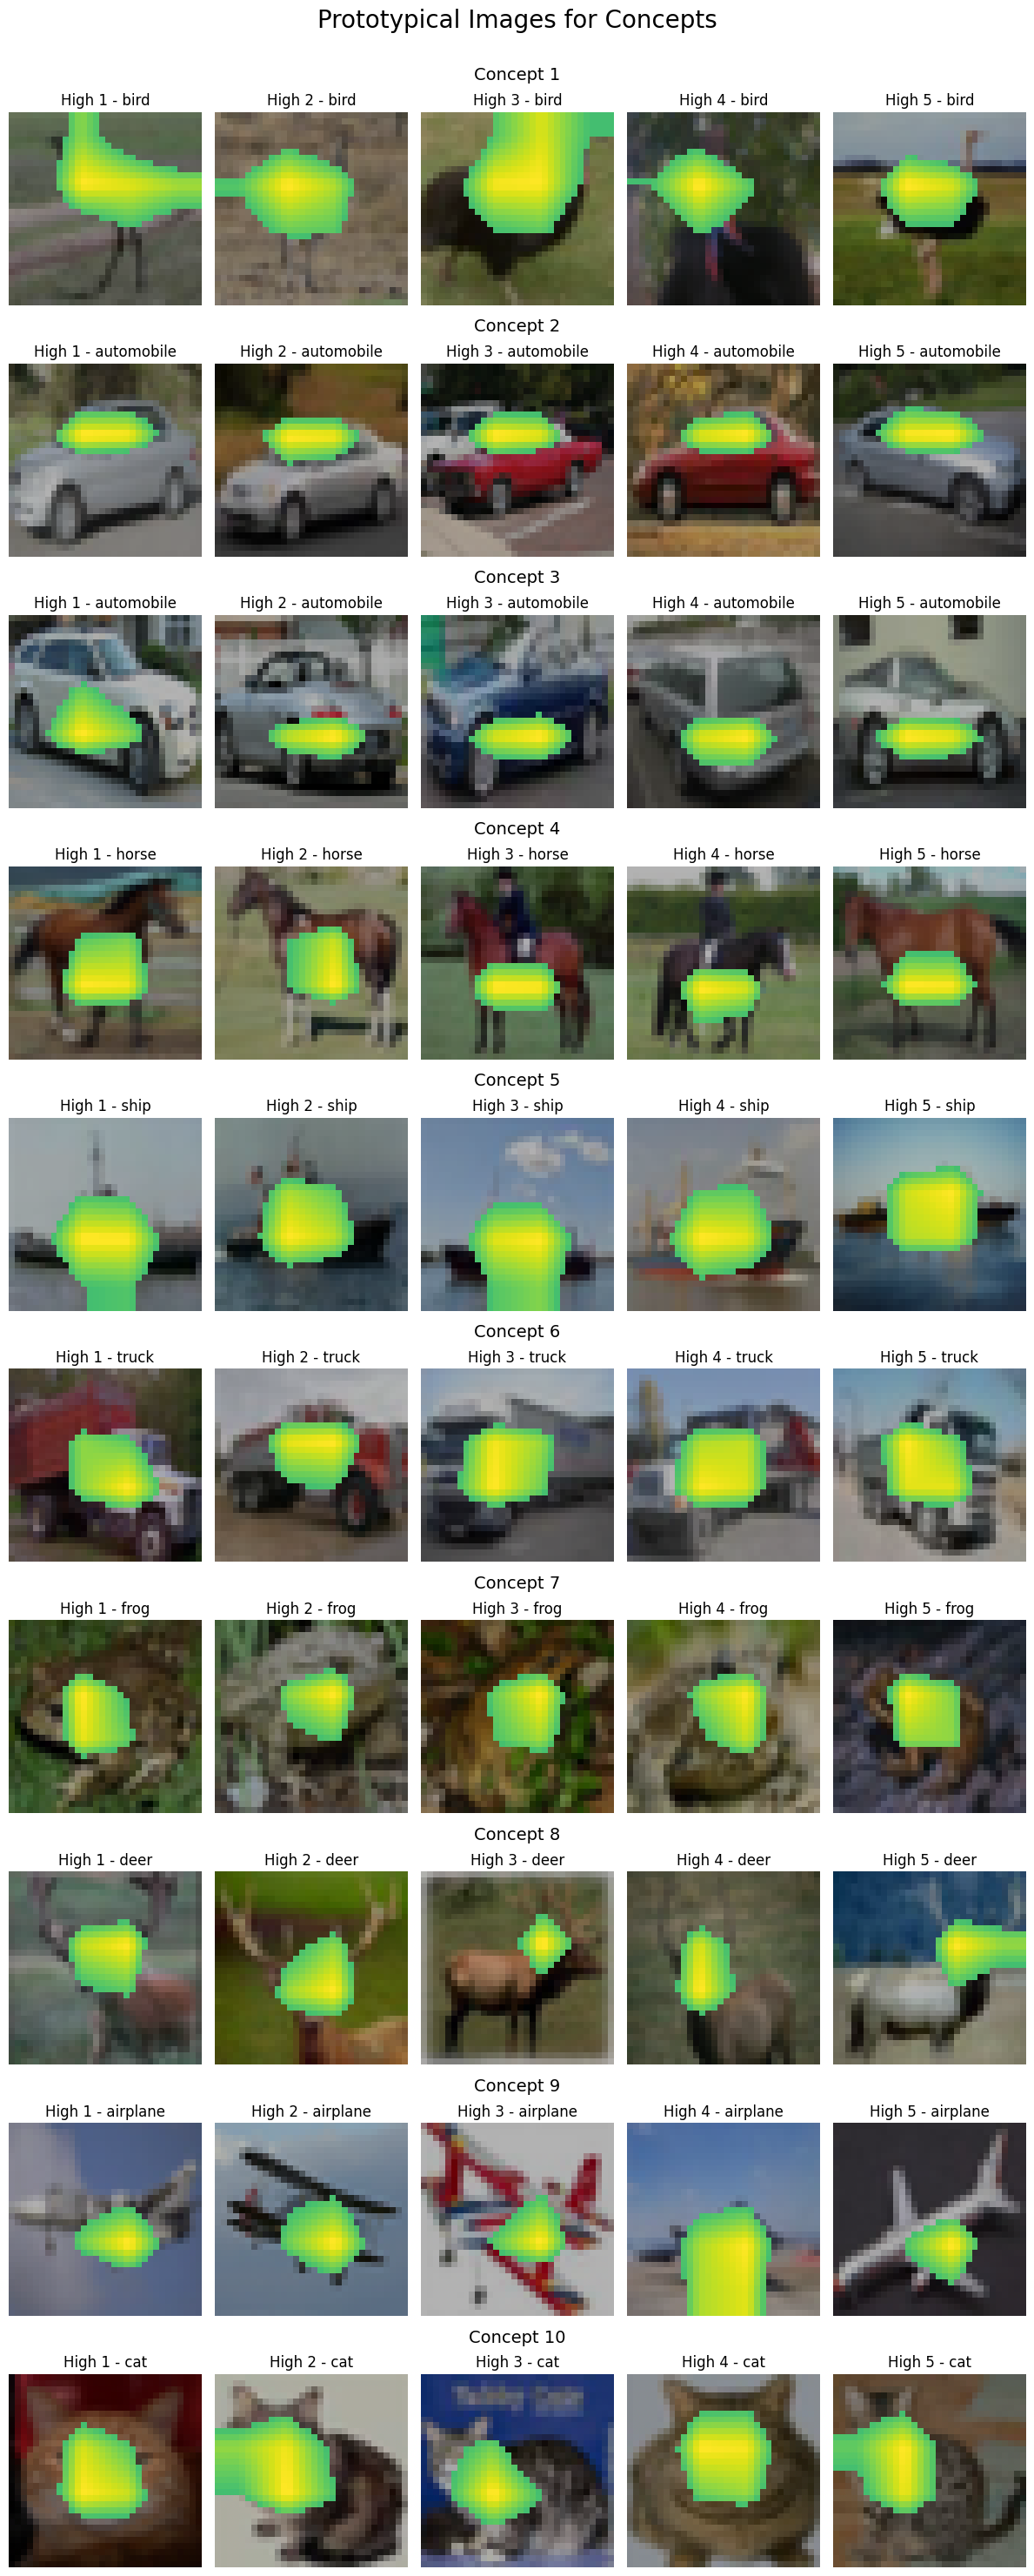

In [ ]:
concept_plots_save_path = 'concept_plots.pdf'
plot_concept_images(avg_concept_presence, test_loader, S=heatmaps, threshold=0.7, background_alpha=0.7, plot_lowest=False, save_path=concept_plots_save_path)